# Implémentation de l'algorithme SCP

### Introduction

Ce notebook implémente l'algorithme **SCP (Split Conformal Prediction)** afin de prédire des **intervalles de prédiction** pour le prix de voitures à partir de leurs caractéristiques.

Dans le cadre de la SCP standard, un régresseur classique (estimant la moyenne) est utilisé pour les prédictions ponctuelles. Les intervalles sont ensuite construits en ajoutant une marge d'erreur globale, calculée à partir des résidus absolus sur un ensemble de calibration.

Sous des hypothèses d'échangeabilité des données, l'algorithme SCP offre des garanties théoriques sur la couverture **marginale** (en moyenne sur l'ensemble des données).

Toutefois, la SCP standard produit des intervalles **non adaptatifs** : la largeur de l'intervalle est **constante** quelle que soit la voiture testée. Comme nous avons observé une forte hétéroscédasticité lors de l'analyse exploratoire (la variabilité du prix change selon les caractéristiques), cette approche risque d'être sous-optimale : les intervalles seront inutilement larges pour les voitures "faciles" à estimer et dangereusement étroits pour les voitures aux prix plus volatils.

### Mise en place

1.  **Séparation des données :** Les données sont séparées en trois ensembles : entraînement, calibration et test.
2.  **Entraînement du modèle :** Un régresseur (ex: Random Forest ou Linéaire) est entraîné sur l'ensemble d'entraînement pour prédire le prix moyen.
3.  **Calibration :**
    * Le modèle effectue des prédictions sur l'ensemble de calibration.
    * On calcule les **résidus absolus** (l'erreur absolue) pour chaque point de cet ensemble.
    * On détermine la constante $q$ correspondant au quantile $(1-\alpha)$ de ces résidus. Cette valeur $q$ définit la demi-largeur fixe de l'intervalle.
4.  **Construction des intervalles :** Pour chaque point de l'ensemble de test, l'intervalle de prédiction est construit en prenant la prédiction du régresseur et en ajoutant et soustrayant $\pm q$.
5. **Évaluation du modèle:** Le modèle est évalué sur l'ensemble de test en utilisant diverses métriques.

### Chargement des données

In [ ]:
import polars as pl
import numpy as np

# Polars display options
pl.Config.set_tbl_hide_column_data_types(True)
pl.Config.set_tbl_hide_dataframe_shape(True)
pl.Config.set_float_precision(2)

# Load preprocessed data
df = pl.read_parquet("../../data/car_prices_clean.parquet")

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (19161, 18)


Price,Levy tax,Brand,Model,Production year,Category,Leather interior,Fuel type,Engine volume (L),Mileage (km),Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo
13328,1399,"""LEXUS""","""RX 450""",2010,"""Jeep""",true,"""Hybrid""",3.50,186005,6.00,"""Automatic""","""4x4""",4,"""Left wheel""","""Silver""",12,false
16621,1018,"""CHEVROLET""","""Equinox""",2011,"""Jeep""",false,"""Petrol""",3.00,192000,6.00,"""Tiptronic""","""4x4""",4,"""Left wheel""","""Black""",8,false
8467,null,"""HONDA""","""FIT""",2006,"""Hatchback""",false,"""Petrol""",1.30,200000,4.00,"""Variator""","""Front""",4,"""Right-hand drive""","""Black""",2,false
3607,862,"""FORD""","""Escape""",2011,"""Jeep""",true,"""Hybrid""",2.50,168966,4.00,"""Automatic""","""4x4""",4,"""Left wheel""","""White""",0,false
11726,446,"""HONDA""","""FIT""",2014,"""Hatchback""",true,"""Petrol""",1.30,91901,4.00,"""Automatic""","""Front""",4,"""Left wheel""","""Silver""",4,false


### Définition des données du modèle

In [33]:
target = "Price"
numerical_features = [
    "Production year",
    "Leather interior",
    "Engine volume (L)",
    "Mileage (km)",
    "Cylinders",
    "Doors",
    "Airbags",
    "Turbo",
]
categorical_features = [
    "Brand",
    "Category",
    "Fuel type",
    "Gear box type",
    "Drive wheels",
    "Wheel",
    "Color",
]
features = numerical_features + categorical_features

f"Unused features: {set(df.columns) - set(features)}"

"Unused features: {'Price', 'Levy tax', 'Model'}"

### Séparation des données

La taille de l'ensemble de calibration est choisie de manière à garantir un taux de couverture satisfaisant, tandis que la taille de l'ensemble de test permet de généraliser les performances du modèle.

In [34]:
from sklearn.model_selection import train_test_split

y = df.get_column("Price")
X = df.select(features)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)
X_calib, X_test, y_calib, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train set size (60%): {X_train.shape[0]}")
print(f"Calibration set size (20%): {X_calib.shape[0]}")
print(f"Test set size (20%): {X_test.shape[0]}")

Train set size (60%): 11496
Calibration set size (20%): 3832
Test set size (20%): 3833


### Définition du modèle

Le régresseur utilisé est `sklearn.ensemble.HistGradientBoostingRegressor` qui est un modèle de gradient boosting efficace pour les tâches de régression. Ce modèle est choisi car il ne nécessite pas de normalisation des données numériques et gère nativement les données catégorielles et manquantes.

In [35]:
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor(
    loss="squared_error",
    learning_rate=0.1,
    max_iter=2000,
    max_depth=None,
    categorical_features="from_dtype",
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42,
)

### Entraînement du modèle

Les hyperparamètres du modèle sont optimisés sur l'ensemble d'entraînement avec `sklearn.model_selection.HalvingRandomSearchCV` avec une cross-validation à 5 plis sur l'ensemble d'entraînement. Les meilleurs hyperparamètres sont ensuite utilisés pour entraîner le modèle final sur l'ensemble d'entraînement complet (`refit=True`).

In [36]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint, uniform

param_distributions = {
    "max_leaf_nodes": randint(20, 80),
    "learning_rate": uniform(0.05, 0.15),
    "min_samples_leaf": randint(20, 100),
    "l2_regularization": uniform(0, 0.1),
}

search = HalvingRandomSearchCV(
    model,
    param_distributions=param_distributions,
    n_candidates=50,
    min_resources=200,
    cv=5,
    n_jobs=-1,
    random_state=42,
    refit=True,
)
search.fit(X_train, y_train);

### Split Conformal Prediction (SCP)

In [37]:
# 1. Predict on calibration set
df_calib = pl.DataFrame(
    {
        "True Price": y_calib,
        "Predicted Price": search.best_estimator_.predict(X_calib),
    }
)

# 2. Compute nonconformity scores
df_calib = df_calib.with_columns(
    nonconformity_score=(pl.col("Predicted Price") - pl.col("True Price")).abs()
)

# 3. Compute quantile of nonconformity scores
alpha = 0.1
q_level = np.ceil((df_calib.height + 1) * (1 - alpha)) / df_calib.height
qhat = df_calib["nonconformity_score"].quantile(q_level, interpolation="linear")
# Le cadre théorique stricte impose de prendre la masse englobante supérieure (interpolation="higher").
# Mais en pratique l'interpolation linéaire semble plus pertinente.

f"SCP calibration qhat (α={alpha}): {qhat:.3f} at level {q_level:.4f}"

'SCP calibration qhat (α=0.1): 12258.113 at level 0.9003'

### Distribution des scores de non-conformité

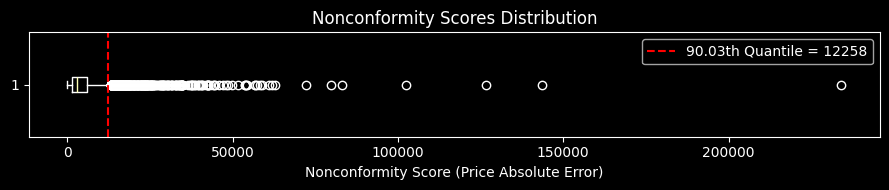

In [38]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 2))
plt.boxplot(df_calib["nonconformity_score"], vert=False)
plt.axvline(
    qhat,
    color="red",
    linestyle="--",
    label=f"{q_level * 100:.2f}th Quantile = {qhat:.0f}",
)
plt.gca().set_title("Nonconformity Scores Distribution")
plt.gca().set_xlabel("Nonconformity Score (Price Absolute Error)")
plt.tight_layout()
plt.legend();

Les bornes inférieures et supérieure de la SCP sont calculées en ajoutant ou enlevant le quantile des scores de non-conformité aux prédictions du modèle : $\hat{y}_{i}^{L} = \hat{y}_{i} - Q_{1-\alpha}(s_{j})$ et $\hat{y}_{i}^{U} = \hat{y}_{i} + Q_{1-\alpha}(s_{j})$ où $s_{j}$ sont les scores de non-conformité calculés sur l'ensemble de calibration.

In [39]:
# Predict on test set
test_predictions = search.best_estimator_.predict(X_test)

df_test = pl.DataFrame(
    {
        "True Price": y_test,
        "Lower Bound": test_predictions - qhat,
        "Predicted Price": test_predictions,
        "Upper Bound": test_predictions + qhat,
    }
)

df_test = pl.concat([df_test, X_test], how="horizontal")
df_test.head()

True Price,Lower Bound,Predicted Price,Upper Bound,Production year,Leather interior,Engine volume (L),Mileage (km),Cylinders,Doors,Airbags,Turbo,Brand,Category,Fuel type,Gear box type,Drive wheels,Wheel,Color
29793,-3912.82,8345.29,20603.41,2004,true,3.50,180800,6.00,4,2,false,"""CHRYSLER""","""Limousine""","""Petrol""","""Automatic""","""Front""","""Left wheel""","""Pink"""
5802,-6261.70,5996.41,18254.53,2013,true,3.50,107800,6.00,4,12,false,"""MERCEDES-BENZ""","""Sedan""","""Diesel""","""Automatic""","""Rear""","""Left wheel""","""Grey"""
12544,-2569.01,9689.10,21947.22,2013,true,2.40,98456,4.00,4,0,false,"""HYUNDAI""","""Sedan""","""Petrol""","""Automatic""","""Front""","""Left wheel""","""Black"""
21326,8823.54,21081.66,33339.77,2012,true,2.40,113000,4.00,4,8,false,"""TOYOTA""","""Sedan""","""Petrol""","""Tiptronic""","""Front""","""Left wheel""","""Silver"""
26255,10768.46,23026.58,35284.69,2011,true,2.00,142000,4.00,4,4,false,"""HYUNDAI""","""Jeep""","""Diesel""","""Automatic""","""Front""","""Left wheel""","""Black"""


### Évaluation des performances

In [40]:
from utils import parse_into_expression, IntoExpr


def coverage(
    lower_bound: IntoExpr,
    upper_bound: IntoExpr,
    value: IntoExpr = "True Price",
) -> pl.Expr:
    """Return an expression to compute the coverage of an interval over values."""

    # Note: parse_into_expression allows to pass:
    # - strings which are interpreted as column names
    # - polars expressions which are evaluated within the DataFrame context
    # - literal values such as 0 for the lower_bound
    value = parse_into_expression(value)
    lower_bound = parse_into_expression(lower_bound)
    upper_bound = parse_into_expression(upper_bound)

    is_covered = value.is_between(lower_bound, upper_bound)
    return (is_covered.mean().mul(100).round(1).cast(pl.Utf8) + pl.lit("%")).alias(
        "Coverage"
    )


def pinball_loss(y_true: IntoExpr, y_pred: IntoExpr, alpha: float) -> pl.Expr:
    """Return an expression to compute the Pinball loss."""

    y_true = parse_into_expression(y_true)
    y_pred = parse_into_expression(y_pred)

    residual = y_true - y_pred
    loss = pl.max_horizontal(alpha * residual, (alpha - 1) * residual)
    return loss.mean().cast(pl.Int32).alias(f"Pinball q_{alpha}")


df_test.select(
    coverage("Lower Bound", "Upper Bound"),
    coverage(0, "Lower Bound").name.suffix(f" q{alpha / 2:.2f}"),
    coverage(0, "Upper Bound").name.suffix(f" q{1 - (alpha / 2):.2f}"),
    coverage(0, "Predicted Price").name.suffix(" Regressor"),
    pinball_loss("True Price", "Lower Bound", alpha / 2),
    pinball_loss("True Price", "Upper Bound", 1 - (alpha / 2)),
)

Coverage,Coverage q0.05,Coverage q0.95,Coverage Regressor,Pinball q_0.05,Pinball q_0.95
"""90.2%""","""4.0%""","""94.2%""","""53.5%""",966,1376


Le taux de couverture global (90.2%) est conforme à ce qui est attendu (90%). Les garanties théoriques de la SCP sont respectées. 

En s'intéressant aux bornes basses et hautes du modèle, on aperçoit cependant une sous-couverture (de respectivement -1.1% et -0.9%).

On observe un biais du régresseur qui prédit plus souvent une valeur supérieure à la vraie valeur (taux de couverture de 53.4%). Toutefois, ce biais positif n'explique pas le biais négatif des bornes de la SCP. La bonne explication est que la SCP produit des bornes symétriques autour de la prédiction du régresseur, hors la distribution des prix n'est pas symétrique (skewed à droite). La pinball loss confirme que les erreurs sont plus fréquentes et plus grandes dans les niveaux de prix élevés.

Des variantes asymétriques de la SCP existent où le quantile des erreurs est calculé séparément pour les bornes inférieures et supérieures, permettant de gérer une asymétrie dans la distribution de la variable d'intérêt.

### Visualisation des prédictions pour un échantillon de l'ensemble de test

In [41]:
import altair as alt

alt.data_transformers.enable("vegafusion")

df_sample = (
    df_test.sample(50, seed=42)
    .sort("True Price")
    .with_row_index("index")
    .with_columns(
        is_covered=pl.col("True Price").is_between(
            pl.col("Lower Bound"), pl.col("Upper Bound")
        )
    )
)

In [42]:
chart = alt.Chart(df_sample, title=f"SCP Intervals (50 samples, α={alpha})").encode(
    alt.X("index:Q", title="Random sample (sorted by price)"),
    tooltip=["index", "True Price", "Lower Bound", "Upper Bound", "is_covered"],
)

points = chart.mark_point(size=60, filled=True).encode(
    alt.Y("True Price:Q"),
    alt.Color("is_covered:N", title="Covered", scale={"range": ["red", "green"]}),
)

intervals = chart.mark_errorbar(ticks=True).encode(
    alt.Y("Lower Bound:Q"), alt.Y2("Upper Bound:Q")
)

(points + intervals).properties(width=800)

alt.LayerChart(...)

### Analyse de la couverture par sous-groupes

In [43]:
df_test.group_by("Brand").agg(
    coverage("Lower Bound", "Upper Bound"), pl.len().alias("Count")
).sort("Count", descending=True).head(10)

Brand,Coverage,Count
"""HYUNDAI""","""95.4%""",761
"""TOYOTA""","""88.6%""",755
"""MERCEDES-BENZ""","""83.6%""",383
"""FORD""","""93.3%""",223
"""HONDA""","""93.3%""",210
"""CHEVROLET""","""95.2%""",209
"""LEXUS""","""75.1%""",205
"""BMW""","""85.2%""",196
"""NISSAN""","""95.2%""",146
"""SSANGYONG""","""97.1%""",103


In [44]:
df_test.group_by("Fuel type").agg(
    coverage("Lower Bound", "Upper Bound"), pl.len().alias("Count")
).sort("Count", descending=True)

Fuel type,Coverage,Count
"""Petrol""","""87.9%""",2018
"""Diesel""","""91.3%""",783
"""Hybrid""","""92.3%""",741
"""LPG""","""96.6%""",176
"""CNG""","""100.0%""",94
"""Plug-in Hybrid""","""100.0%""",20
"""Hydrogen""","""100.0%""",1


In [45]:
df_test.group_by("Production year").agg(
    coverage("Lower Bound", "Upper Bound"), pl.len().alias("Count")
).sort("Production year", descending=True).head(15)

Production year,Coverage,Count
2020,"""40.0%""",10
2019,"""60.7%""",61
2018,"""65.3%""",101
2017,"""82.9%""",193
2016,"""84.3%""",300
…,…,…
2010,"""92.7%""",289
2009,"""89.0%""",118
2008,"""95.4%""",151
2007,"""90.5%""",95


**Analyse par sous-groupes:**

La couverture varie selon les caractéristiques du véhicule (kilométrage, année, marque). Ces variations sont attendues car la SCP fournit une garantie marginale (sur l'ensemble du jeu de test), pas conditionnelle (par sous-groupe).